# Covid-19 Model Extended - Additional application of pandas
### Reference:
* McKinney Chpt - 4 - numpy
* McKinney Chpt - 5 - pandas essentials
* McKinney Chpt - 6 - Data loading and files
* McKinney Chpt - 7 - Data cleaning and preparation
* McKinney Chpt - 8 - Data wrangling and joins
* McKinney Chpt - 9 - Visualization

<pre>_____________________________________________________________________________________________________</pre>

# CS2311-Algorithms and Data Structures With Python
## Homework 7A2
## Due Date: See Blackboard

## Student Name: Laura Moses

**SUBMISSION GUIDELINES**

1. First design, develop and test your code in a Jupyter notebook or other development environment
   - You can expirement and try different things in this notebook
2. Then copy your final code and markdown cells into the Jupyter Notebook file (.ipynb) provided for the assignment and submit to Blackboard
   - **Your submission file should be named HW7A2Final.ipynb**
   - I must be able to open and run your notebook in order to grade it
3. Note that the Jupyter notebook provided for final submission may contain testing code to help you check that your output and expected match.  
   - Follow the instructions in the notebook for copying your code and running the testing code
   - The instructor may run additional tests to check that your code runs correctly
4. If asked, also provide any supporting files or images requested in the assignment
   - If there are multiple files to submit you should zip the files into one folder and submit the folder

**GRADING CRITERIA:**
1. Good documentation/comments and program readability using both markdown cells and code comments
2. Algorithm/pseudo-code is explained in a markdown cell and is efficiently written
3. Program runs correctly for test cases with no syntax errors or logical errors

***The instructor should be able to reproduce your work from your notebook.***

<pre>_____________________________________________________________________________________________________</pre>

# Topic:  Pandas  - 75 Points 

## 1.	[75 points] Extension of the Covid-19 SIR Model and pandas applications
We are interested in extending the Covid-19 model we started in Homework 7 and applying additional pandas methods and techniques in the process.

<pre>_____________________________________________________________________________________________________</pre>

# Recap of SIR Epidemic Model

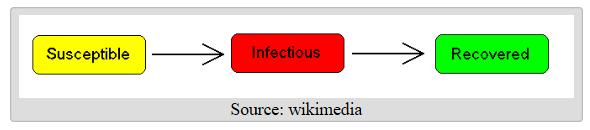

To model the dynamics of the outbreak we need three differential equations, one for the change in each group, where $\beta$ is the parameter that controls the transition between ${S}$ and ${I}$ and $\gamma$  which controls the transition between ${I}$ and ${R}$ :

$$ \frac{dS}{dt} = -\beta\frac{IS}{N}$$

$$ \frac{dI}{dt} = \beta\frac{IS}{N}-\gamma{I}$$

$$ \frac{dR}{dt} = \gamma{I}$$  



The constant $\beta$ represents the contact rate of the disease (an infected individual comes into contact with $\beta{N}$ other individuals per unit time); the value of  must be greater than or equal to zero.

The constant $\gamma$ is the mean recovery rate (which will always be greater than or equal to zero); 

It is important to remember that our total population is described by the sum of susceptible, infected, and recovered individuals:

$$ {N(t)} = {S(t) + I(t) + R(t)}$$

Now lets see if we can fit this model to the case data that is being reported in the US.  We will use the data reported in wikipedia which is updated daily.

https://en.wikipedia.org/wiki/2020_coronavirus_outbreak_in_the_United_States or look in 
https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/United_States_medical_cases

Take a look at the web site and note the table summarizing all the case statitics - we need to extract the 
total cases from this table.  By default pd.read_html returns a list of all the tables on the page as data frames

**NOTE:** Other USA sources (excel files) that you may want to look at for further analysis be found at these links:

https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/  (USA by state/county)

https://www.dshs.state.tx.us/news/updates.shtm#coronavirus  (TX by county)

<pre>_____________________________________________________________________________________________________</pre>

<a id='TOC'></a>
# Table of Contents: USA/State CoVid19 Cases

<br>[1. Setup and Variables/Assumptions](#VarSetup)
<br>....Task 1.1: Set up your input variables and flags
<br>....Task 1.2: Select region, make assumption of hospital beds, set up states, population and hospital beds
<br>....Task 1.3: Set up a state code, population and hospital bed dataframe by scraping data from web
<br>....Task 1.4: Set up a USA 8 x 11 "map grid" for our small multiple charts
<br>[2. Scrape Data](#ScrapeData)
<br>....Task 2.1: Scrape data from web and locate the right table
<br>....Task 2.2: Clean-up and wrangle - create a datetime column without date gaps
<br>....Task 2.3: Clean-up and wrangle - Convert non-numeric data to NaN
<br>....Task 2.4: Clean-up and wrangle - Now set "PDate" as datetime index and fill-in data gaps with NaN
<br>....Task 2.5: Clean-up and wrangle - create cumulative sum of cases for each state and rename columns
<br>[3. Plot Historical Data](#PlotData)
<br>....Task 3.1: Do quick graph of dataframe for select states
<br>....Task 3.2: Select portion of data to start plotting from i.e. after specified number of cases recorded
<br>....Task 3.3: Plot cases and log of cases of Region to see how cases as growing - customize chart
<br>....Task 3.4: Plot all states as small multiples on the US map 8x11 grid
<br>[4. Calculate Change in Slope of Exponetial Curve](#Slope)
<br>....Task 4.1: Put log infected data into a dataframe so we can use the .diff() method in pandas
<br>....Task 4.2: Plot the slope and change in slope curves for the Region specified
<br>....Task 4.3: Plot change is slope of curve for all states as small multiples on the US map 8x11 grid
<br>[5. Fit Model](#ModelFitting)
<br>....Task 5.1: set up initial conditions for model
<br>....Task 5.2: Set up the SIR model function as per the formulas
<br>....Task 5.3: set up the odeint_chg_beta() function that does the numerical integration (i.e. solving) of the SIR equations
<br>....Task 5.4: set up a function to calculate the Residual Sum of Squares between SIR model and observed data
<br>....Task 5.5: do a least squares fit on RSS to get Beta and Gamma that minimizes the RSS
<br>[6. Base Case - Beta as per model fit with Beta Increasing](#BaseCase)
<br>....Task 6.1: Set up variables and assumptions
<br>....Task 6.2: Project the spread of the epidemic based on SIR model and best Beta & Gamma fit to data
<br>....Task 6.3: Plot SIR data and projections
<br>....Task 6.4: Report summary data from SIR model

<pre>_____________________________________________________________________________________________________</pre>

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [2]:
# display() does a pretty print of dataframes so they look like they do in jupyter 
from IPython.core.display import display, HTML
# set the size of the scrolling window in jupyter to be wider
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

<a id='VarSetup'></a>
# 1 Setup and variable assumptions
[TOC](#TOC)

## **Our to do list: Fill-in the missing portions of code and match the output shown**

_1. Setup and variable assumptions:_

- **Task 1.1**: Set up your input variables and flags
- **Task 1.2**: Select region, make assumption of hospital beds, set up states, population and hospital beds
- **Task 1.3**: Set up a state code, population and hospital bed dataframe by scraping data from web
- **Task 1.4**: Set up a USA 8 x 11 "map grid" for our small multiple charts

### Methods to use:
* `pd.read_html()`  - scrape web for list of tables as dataframes
* `pd.merge()`      - merge dataframes on index
* `.columns`        - use to rename columns
* `pd.read_excel()` - read from excel files, can specify sheet to read from
* `.to_excel()`     - write a dataframe to excel file
* `.dropna()`       - drop rows with NaN
* `.reset_index()`  - reset index of dataframe to default numeric

### 1.1 Set up your input variables and flags

In [3]:
# Global inputs - Use Named constants
REGION              =  "USA"
UNDER_REPORT_FACTOR =  1                        # multiply number of cases by this amount to account for underreporting
CASE_STARTS         =  8_000_000                # fit curves to data starting at these number of cases
TRACE                = True                     # General debug flag for printing output

### 1.2 Select region, make assumption of hospital beds, set up states, population and hospital beds

In [4]:
# set population by region
hbf  = 2.8/1000  # Estimate of hospital beds = 28 per 1000 of population

### 1.3 Set up a state code, population and hospital bed dataframe by scraping data from web

First, set up a dataframe with state populations, state codes and a estimate of hospital beds.  We will use this information later in our graphs.  We are going to do this by scraping the web for the data for population an postal codes and merging it into a data frame

First get data on population.  Using this website to scrape the tables.  Looks like there is only one to select.

In [5]:
# get populations for the states - I found this site
tables = pd.read_html('https://www.worldatlas.com/articles/us-states-by-population.html')

# how many tables did we scrape from page?  How to locate the one with the case stats?
len(tables)

1

In [6]:
# inspect
st_pop_df = tables[0]
st_pop_df.head()

,Rank,State,Population
0,1.0,California,39937489
1,2.0,Texas,29472295
2,3.0,Florida,21992985
3,4.0,New York,19440469
4,5.0,Pennsylvania,12820878


In [7]:
# Set the column heading to be unambigous - sometimes your scraped columns have hidden characters so we will overide
# column headings
st_pop_df.columns = ["Rank","State","Pop"]
st_pop_df.head()

,Rank,State,Pop
0,1.0,California,39937489
1,2.0,Texas,29472295
2,3.0,Florida,21992985
3,4.0,New York,19440469
4,5.0,Pennsylvania,12820878


In [8]:
# set the index to be the "State" column
st_pop_df.set_index("State",drop=True,inplace=True)

In [9]:
st_pop_df.head()

,Rank,Pop
State,,
California,1.0,39937489
Texas,2.0,29472295
Florida,3.0,21992985
New York,4.0,19440469
Pennsylvania,5.0,12820878


Next get the postal codes.  We will use this web link.  Looks like there is just one table.

In [10]:
# get state codes so we can map states to codes
tables = pd.read_html('https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes')

In [11]:
# how many tables did we scrape from page?  How to locate the one with the case stats?
len(tables)

2

In [12]:
#  use table[0]
tables[0].head()

,State/District,Abbreviation,Postal Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [13]:
# Rename columns to be safe. Also we are going to merge on "State" in a bit
st_codes_df = tables[0]
st_codes_df.columns = ["State","Abbrev","PostCode"]
st_codes_df.head()

,State,Abbrev,PostCode
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA


In [14]:
# set the index to "State" to make it easy to merge dataframes later. Drop existing index and do inplace
st_codes_df.set_index("State",drop=True,inplace=True)

In [15]:
st_codes_df.head()

,Abbrev,PostCode
State,,
Alabama,Ala.,AL
Alaska,Alaska,AK
Arizona,Ariz.,AZ
Arkansas,Ark.,AR
California,Calif.,CA


Now we will merge on State and create a new column for an estimate of hospital beds.  The stat that we are using is that there are 2.8 hospital beds/1000 population.  This variable has been set as hbf earlier in our program.

In [16]:
# now merge the two data frame on the "State" index. Set up a column "HospBeds" in dataframe with 
# estimate of hospital bed capacity = "Pop"*hbf  (hbf is the hospital bed factor we set previously)
st_info_df = pd.merge(st_pop_df,st_codes_df,on="State")
st_info_df['HospBeds'] = st_info_df['Pop']*hbf

In [17]:
# reset the index of the dataframe to default numeric
st_info_df= st_info_df.reset_index()

In [18]:
st_info_df.head()

,State,Rank,Pop,Abbrev,PostCode,HospBeds
0,California,1.0,39937489,Calif.,CA,111824.9692
1,Texas,2.0,29472295,Tex.,TX,82522.4260
2,Florida,3.0,21992985,Fla.,FL,61580.3580
3,New York,4.0,19440469,N.Y.,NY,54433.3132
4,Pennsylvania,5.0,12820878,Pa.,PA,35898.4584


Now we are going to set up a "US Grid" 8 rows x 11 columns to approximate the geographic location of states on a sub-plot matrix of small multiple graphs.

### 1.4 Set up a USA map grid for our small multiple charts

In [19]:
# Read the excel USA plot grid coordinates from the excel file into a data frame.  set the index column to "PostCode". 
# Notice the you can specify the sheet you want to read from.
usplotgrid_df = pd.read_excel('USplotgrid.xlsx', 'Sheet1',index_col="PostCode")

In [20]:
# drop any rows with missing data
usplotgrid_df=usplotgrid_df.dropna()

In [21]:
usplotgrid_df.head()

,ax0,ax1
PostCode,,
CA,4,0
TX,7,3
FL,7,8
NY,2,8
PA,3,8


<pre>_____________________________________________________________________________________________________</pre>

<a id='ScrapeData'></a>
# 2. Scrape Data
[TOC](#TOC)

## **Our to do list:**

_2. Scrape Wikipedia Data:_

- **Task 2.1**: Scrape data from web and locate the right table
- **Task 2.2**: Clean-up and wrangle - create a datetime column without date gaps
- **Task 2.3**: Clean-up and wrangle - Convert non-numeric data to NaN
- **Task 2.4**: Clean-up and wrangle - Now set "PDate" as datetime index and fill-in data gaps with NaN
- **Task 2.5**: Clean-up and wrangle - create cumulative sum of cases for each state and rename columns

### Methods to use:
* `pd.read_html`
* `enumerate()`,`.columns`,`.droplevel()`,`.drop()`,
* `from datetime import datetime` - library for handling datetime data
* `datetime.now()`                - get today's date
* `pd.date_range()`               - set up an index for a range of dates
* `pd.to_datetime()`              - convert string to datetime type
* `f = lambda`, `.map(f)`
* `pd.to_numeric()`, `.apply()`
* `.set index()`,`.reindex()`
* `.cumsum()`, `.rename()`
* `.duplicated()` - check for duplicated values in a dataframe (can select index or subset of columns)
* `pd.to_numeric()` - converts data to numeric.  Can coerce errors to NaN
* `.astype(np.float64)` - convert datatype to float

Now scrape the case data for our model fits from the web.  There are many sources but Wikipedia has a nice summary table for the USA that is updated every day.

### 2.1 Scrape data from web and locate the right table

In [22]:
# Scrape latest US data
tables = pd.read_html('https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/United_States_medical_cases')

In [23]:
# how many tables did we scrape from page?  How to locate the one with the case stats?
if TRACE: print(len(tables))

24


In [24]:
# locate correct table in page - there is a hierarchical index of "Cml", "Cml" in the table we are looking for so 
# lets try and locate the correct table by searching for these column headings
for i,table in enumerate(tables):    # enumerate returns an index and the value in the table
    if TRACE: print(table.columns)
    #print("Table: ",str(i),table.head(1))
    # look for "Cml" column in table to identify index of table
    if ("Confirmed","Cml") in table.columns:
        ref = i
if TRACE: print(ref)

MultiIndex([(               'Date',                'Date'),
            (               'West',                  'AK'),
            (               'West',                  'AZ'),
            (               'West',                  'CA'),
            (               'West',                  'CO'),
            (               'West',                  'HI'),
            (               'West',                  'ID'),
            (               'West',                  'MT'),
            (               'West',                  'NM'),
            (               'West',                  'NV'),
            (               'West',                  'OR'),
            (               'West',                  'UT'),
            (               'West',                  'WA'),
            (               'West',                  'WY'),
            (            'Midwest',                  'IA'),
            (            'Midwest',                  'IL'),
            (            'Midwest',     

In [25]:
# ref holds the data for the table we are interested in - we want the series (i.e. column with the data)
# notice the dups and irrelevant text "Daily Sources .... that we will have to remove"
dat = tables[ref]["Confirmed"]["Cml"]
if TRACE: display(dat)

0                                                      1
1                                                      2
2                                                      3
3                                                      5
4                                                      6
                             ...                        
307                                                  Cml
308                                            Confirmed
309                                                  NaN
310    Notes: Numbers shown above as of date of confi...
311    Daily sources Jan 21 [72] Jan 24 [73] Jan 25 [...
Name: Cml, Length: 312, dtype: object

In [26]:
# Inspect - Data frame has a hierarchical index by region
dat = tables[ref][["Date","West","Midwest", "South","Northeast","Confirmed"]]
if TRACE: display(dat.head())

Date         West                                     ... Northeast       \
     Date  Date.1   AK   AZ   CA   CO   HI   ID   MT   NM  ...        MD   ME   
0  Jan 21  Jan 21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
1  Jan 24  Jan 24  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
2  Jan 25  Jan 25  NaN  NaN    1  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
3  Jan 26  Jan 26  NaN    1    1  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
4  Jan 30  Jan 30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   

                                Confirmed      
    NH   NJ   NY   PA   RI   VT       New Cml  
0  NaN  NaN  NaN  NaN  NaN  NaN         1   1  
1  NaN  NaN  NaN  NaN  NaN  NaN         1   2  
2  NaN  NaN  NaN  NaN  NaN  NaN         1   3  
3  NaN  NaN  NaN  NaN  NaN  NaN         2   5  
4  NaN  NaN  NaN  NaN  NaN  NaN         1   6  

[5 rows x 55 columns]

In [27]:
# Save out the state column names in level1 and drop the level0 index
dat.columns
col_names = [x[1] for x in dat.columns]
col_names
dat.columns.droplevel()
dat
dat.columns = col_names
if TRACE: display(dat.head())

,Date,Date.1,AK,AZ,CA,CO,HI,ID,MT,NM,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
0,Jan 21,Jan 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,Jan 24,Jan 24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
2,Jan 25,Jan 25,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3
3,Jan 26,Jan 26,NaN,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5
4,Jan 30,Jan 30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6


In [28]:
dat = dat.drop("Date.1",axis=1)

### 2.2 Clean-up and wrangle - create a datetime column without date gaps

In [29]:
# There are gaps in the date index so set up a daily date index starting Jan 21 to now to fill in missing values
from datetime import datetime
now = datetime.now()
idx = pd.date_range(start='2020-01-21',end = now )
if TRACE: display(idx)

DatetimeIndex(['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30',
               ...
               '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21',
               '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
               '2020-11-26', '2020-11-27'],
              dtype='datetime64[ns]', length=312, freq='D')

In [30]:
# Locate the end of the table, look for the "Total" string and its index
e_idx = dat["Date"][dat.Date=="Total"].index[0]
if TRACE: display(e_idx)

306

In [31]:
# Make a copy of this slice of dataframe
dat = dat.iloc[:e_idx,:].copy()
if TRACE: display(dat.tail())

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
301,Nov 23,498,2659,8337,3689,113,1437,801,2252,2339,...,1658,177,444,3581,5906,4429,2572,85,157518,12030751
302,Nov 24,584,4544,15329,4150,60,1640,1123,2099,2853,...,1667,227,340,4275,4881,5701,851,48,158322,12189073
303,Nov 25,670,3982,18350,4191,108,1773,1061,1855,3159,...,2697,218,394,4042,6265,5993,893,65,178025,12367098
304,Nov 26,553,3476,14640,6053,117,NaN,1117,1694,2542,...,2319,189,NaN,4473,6933,7338,NaN,NaN,118287,12485385
305,Nov 27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# check for duplicate dates
dat.Date.duplicated(keep=False).sum()

18

In [33]:
# which ones? These rows do not contain case data - looking at web page - we see "header row" repeated in middle of
# table - will need to remove these entries from data
dat[dat.Date.duplicated(keep=False)]

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
16,Date,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
17,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
49,Date,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
50,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
81,Date,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
82,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
114,Date,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
115,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
146,Date,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
147,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml


In [34]:
# This function checks if string is a month
def dtstr(x):
    mths = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    found = False
    s = np.nan
    for mth in mths:
        if x.find(mth)==0:
            s = x
            break
    return s

x = "Feb 1 20"
display(dtstr(x))
display(dtstr("Date"))

'Feb 1 20'

nan

In [35]:
# convert date to something we can then convert to datetime string type which is easy to manipulate
f = lambda x: dtstr(x[0:10]+" 20")
dat.loc[:,"Date"] = dat["Date"].map(f)
if TRACE: display(dat)

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
0,Jan 21 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,Jan 24 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
2,Jan 25 20,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3
3,Jan 26 20,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5
4,Jan 30 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Nov 23 20,498,2659,8337,3689,113,1437,801,2252,2339,...,1658,177,444,3581,5906,4429,2572,85,157518,12030751
302,Nov 24 20,584,4544,15329,4150,60,1640,1123,2099,2853,...,1667,227,340,4275,4881,5701,851,48,158322,12189073
303,Nov 25 20,670,3982,18350,4191,108,1773,1061,1855,3159,...,2697,218,394,4042,6265,5993,893,65,178025,12367098
304,Nov 26 20,553,3476,14640,6053,117,NaN,1117,1694,2542,...,2319,189,NaN,4473,6933,7338,NaN,NaN,118287,12485385


In [36]:
# we know we have some non-dates in Date column let's check
dat[dat.Date.isna()]

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
16,NaN,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
17,NaN,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
49,NaN,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
50,NaN,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
81,NaN,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
82,NaN,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
114,NaN,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
115,NaN,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
146,NaN,West,West,West,West,West,West,West,West,West,...,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Northeast,Confirmed,Confirmed
147,NaN,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml


In [37]:
# let's drop these rows for the Date column
dat.dropna(subset=["Date"],how="any",inplace=True)

In [38]:
# check now  - looks good
dat[dat.Date.isna()]

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml


In [39]:
# Create a new column PDate of datetime values
dat.loc[:,'PDate'] = pd.to_datetime(dat.loc[:,"Date"], format='%b %d %y')
if TRACE: display(dat.head())

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,ME,NH,NJ,NY,PA,RI,VT,New,Cml,PDate
0,Jan 21 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2020-01-21
1,Jan 24 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2020-01-24
2,Jan 25 20,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2020-01-25
3,Jan 26 20,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,2020-01-26
4,Jan 30 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2020-01-30


In [40]:
dat.head()

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,ME,NH,NJ,NY,PA,RI,VT,New,Cml,PDate
0,Jan 21 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2020-01-21
1,Jan 24 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2020-01-24
2,Jan 25 20,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2020-01-25
3,Jan 26 20,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,2020-01-26
4,Jan 30 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6,2020-01-30


### 2.3 Clean-up and wrangle - Convert non-numeric data to NaN

In [41]:
# convert any values in the state columns that are not numeric to NAN
f = lambda x: pd.to_numeric(x,errors="coerce")
dat.loc[:,"AK":"VT"] = dat.loc[:,"AK":"VT"].apply(f)
if TRACE: display(type(dat["AK"][24]))

numpy.float64

In [42]:
# eliminate empty cells and duplicates due to column sums. pd.to_numeric coerces the non-numeric to NaN.
dat.loc[:,"Cml"] = pd.to_numeric(dat.loc[:,"Cml"],errors = "coerce")

In [43]:
if TRACE: display(dat.head())

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,ME,NH,NJ,NY,PA,RI,VT,New,Cml,PDate
0,Jan 21 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,2020-01-21
1,Jan 24 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,2020-01-24
2,Jan 25 20,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,2020-01-25
3,Jan 26 20,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5.0,2020-01-26
4,Jan 30 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0,2020-01-30


In [44]:
if TRACE: display(dat.tail())

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,ME,NH,NJ,NY,PA,RI,VT,New,Cml,PDate
301,Nov 23 20,498.0,2659.0,8337.0,3689.0,113.0,1437.0,801.0,2252.0,2339.0,...,177.0,444.0,3581.0,5906.0,4429.0,2572.0,85.0,157518,12030751.0,2020-11-23
302,Nov 24 20,584.0,4544.0,15329.0,4150.0,60.0,1640.0,1123.0,2099.0,2853.0,...,227.0,340.0,4275.0,4881.0,5701.0,851.0,48.0,158322,12189073.0,2020-11-24
303,Nov 25 20,670.0,3982.0,18350.0,4191.0,108.0,1773.0,1061.0,1855.0,3159.0,...,218.0,394.0,4042.0,6265.0,5993.0,893.0,65.0,178025,12367098.0,2020-11-25
304,Nov 26 20,553.0,3476.0,14640.0,6053.0,117.0,NaN,1117.0,1694.0,2542.0,...,189.0,NaN,4473.0,6933.0,7338.0,NaN,NaN,118287,12485385.0,2020-11-26
305,Nov 27 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-27


In [45]:
dat.head()

,Date,AK,AZ,CA,CO,HI,ID,MT,NM,NV,...,ME,NH,NJ,NY,PA,RI,VT,New,Cml,PDate
0,Jan 21 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,2020-01-21
1,Jan 24 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,2020-01-24
2,Jan 25 20,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,2020-01-25
3,Jan 26 20,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5.0,2020-01-26
4,Jan 30 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0,2020-01-30


In [46]:
# drop "Date" column - don't need have PDate to work with
dat = dat.drop("Date",axis= 1)

### 2.4 Clean-up and wrangle - Now set "PDate" as datetime index and fill-in data gaps with NaN

In [47]:
# Replace PDate as the index
dat.set_index(['PDate'], drop=True, inplace=True)
if TRACE: display(dat.head())

,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
PDate,,,,,,,,,,,,,,,,,,,,,
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0
2020-01-25,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0
2020-01-26,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5.0
2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0


In [48]:
if TRACE: display(idx)

DatetimeIndex(['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30',
               ...
               '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21',
               '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
               '2020-11-26', '2020-11-27'],
              dtype='datetime64[ns]', length=312, freq='D')

In [49]:
# Now re-index the date index with the daily index idx so that there are no gaps in dates.  Use forward fill to 
# fill in any NaNs with prior values
dat = dat.reindex(idx).fillna(method = 'ffill')
if TRACE: display(dat)

,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0
2020-01-25,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,498.0,2659.0,8337.0,3689.0,113.0,1437.0,801.0,2252.0,2339.0,1163.0,...,1658.0,177.0,444.0,3581.0,5906.0,4429.0,2572.0,85.0,157518,12030751.0
2020-11-24,584.0,4544.0,15329.0,4150.0,60.0,1640.0,1123.0,2099.0,2853.0,1000.0,...,1667.0,227.0,340.0,4275.0,4881.0,5701.0,851.0,48.0,158322,12189073.0
2020-11-25,670.0,3982.0,18350.0,4191.0,108.0,1773.0,1061.0,1855.0,3159.0,1170.0,...,2697.0,218.0,394.0,4042.0,6265.0,5993.0,893.0,65.0,178025,12367098.0
2020-11-26,553.0,3476.0,14640.0,6053.0,117.0,1773.0,1117.0,1694.0,2542.0,1503.0,...,2319.0,189.0,394.0,4473.0,6933.0,7338.0,893.0,65.0,118287,12485385.0


### 2.5 Clean-up and wrangle - create cumulative sum of cases for each state and rename columns

In [50]:
# Now use the case data to create the cumulative sum of cases by day
dat.loc[:,"AK":"VT"]= dat.loc[:,"AK":"VT"].cumsum()
if TRACE: display(dat)

,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,Cml
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0
2020-01-25,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,27109.0,302375.0,1111279.0,202301.0,17456.0,93631.0,56416.0,84148.0,136292.0,66345.0,...,183805.0,9475.0,18085.0,309590.0,602121.0,295033.0,62183.0,3757.0,157518,12030751.0
2020-11-24,27693.0,306919.0,1126608.0,206451.0,17516.0,95271.0,57539.0,86247.0,139145.0,67345.0,...,185472.0,9702.0,18425.0,313865.0,607002.0,300734.0,63034.0,3805.0,158322,12189073.0
2020-11-25,28363.0,310901.0,1144958.0,210642.0,17624.0,97044.0,58600.0,88102.0,142304.0,68515.0,...,188169.0,9920.0,18819.0,317907.0,613267.0,306727.0,63927.0,3870.0,178025,12367098.0
2020-11-26,28916.0,314377.0,1159598.0,216695.0,17741.0,98817.0,59717.0,89796.0,144846.0,70018.0,...,190488.0,10109.0,19213.0,322380.0,620200.0,314065.0,64820.0,3935.0,118287,12485385.0


In [51]:
# Rename the Cml column to USA
dat.rename(columns={'Cml':'USA'}, inplace=True)
if TRACE: display(dat.tail())

,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,USA
2020-11-23,27109.0,302375.0,1111279.0,202301.0,17456.0,93631.0,56416.0,84148.0,136292.0,66345.0,...,183805.0,9475.0,18085.0,309590.0,602121.0,295033.0,62183.0,3757.0,157518,12030751.0
2020-11-24,27693.0,306919.0,1126608.0,206451.0,17516.0,95271.0,57539.0,86247.0,139145.0,67345.0,...,185472.0,9702.0,18425.0,313865.0,607002.0,300734.0,63034.0,3805.0,158322,12189073.0
2020-11-25,28363.0,310901.0,1144958.0,210642.0,17624.0,97044.0,58600.0,88102.0,142304.0,68515.0,...,188169.0,9920.0,18819.0,317907.0,613267.0,306727.0,63927.0,3870.0,178025,12367098.0
2020-11-26,28916.0,314377.0,1159598.0,216695.0,17741.0,98817.0,59717.0,89796.0,144846.0,70018.0,...,190488.0,10109.0,19213.0,322380.0,620200.0,314065.0,64820.0,3935.0,118287,12485385.0
2020-11-27,29469.0,317853.0,1174238.0,222748.0,17858.0,100590.0,60834.0,91490.0,147388.0,71521.0,...,192807.0,10298.0,19607.0,326853.0,627133.0,321403.0,65713.0,4000.0,118287,12485385.0


In [52]:
dat.tail(10)

,AK,AZ,CA,CO,HI,ID,MT,NM,NV,OR,...,MD,ME,NH,NJ,NY,PA,RI,VT,New,USA
2020-11-18,24443.0,283153.0,1048698.0,176706.0,16857.0,86976.0,50617.0,70451.0,125524.0,59681.0,...,171831.0,8563.0,15792.0,289564.0,574073.0,265644.0,55421.0,3204.0,157005,11192629.0
2020-11-19,24933.0,287276.0,1060176.0,182813.0,16964.0,88519.0,51853.0,74116.0,127940.0,60885.0,...,174741.0,8736.0,16320.0,293746.0,579383.0,271989.0,56461.0,3353.0,178160,11370789.0
2020-11-20,25393.0,291747.0,1073181.0,188578.0,17059.0,90305.0,53328.0,77098.0,129779.0,62187.0,...,177094.0,8937.0,16840.0,297372.0,584851.0,278121.0,57511.0,3502.0,187600,11558389.0
2020-11-21,26068.0,295385.0,1088623.0,194691.0,17221.0,91375.0,54577.0,79440.0,131798.0,63680.0,...,179979.0,9079.0,17324.0,302041.0,590824.0,284144.0,58561.0,3589.0,170981,11729370.0
2020-11-22,26611.0,299716.0,1102942.0,198612.0,17343.0,92194.0,55615.0,81896.0,133953.0,65182.0,...,182147.0,9298.0,17641.0,306009.0,596215.0,290604.0,59611.0,3672.0,143863,11873233.0
2020-11-23,27109.0,302375.0,1111279.0,202301.0,17456.0,93631.0,56416.0,84148.0,136292.0,66345.0,...,183805.0,9475.0,18085.0,309590.0,602121.0,295033.0,62183.0,3757.0,157518,12030751.0
2020-11-24,27693.0,306919.0,1126608.0,206451.0,17516.0,95271.0,57539.0,86247.0,139145.0,67345.0,...,185472.0,9702.0,18425.0,313865.0,607002.0,300734.0,63034.0,3805.0,158322,12189073.0
2020-11-25,28363.0,310901.0,1144958.0,210642.0,17624.0,97044.0,58600.0,88102.0,142304.0,68515.0,...,188169.0,9920.0,18819.0,317907.0,613267.0,306727.0,63927.0,3870.0,178025,12367098.0
2020-11-26,28916.0,314377.0,1159598.0,216695.0,17741.0,98817.0,59717.0,89796.0,144846.0,70018.0,...,190488.0,10109.0,19213.0,322380.0,620200.0,314065.0,64820.0,3935.0,118287,12485385.0
2020-11-27,29469.0,317853.0,1174238.0,222748.0,17858.0,100590.0,60834.0,91490.0,147388.0,71521.0,...,192807.0,10298.0,19607.0,326853.0,627133.0,321403.0,65713.0,4000.0,118287,12485385.0


<pre>_____________________________________________________________________________________________________</pre>

In [53]:
# save out the data to excel
dat.to_excel("Covid_19_USA_Scraped_11_27_2020.xlsx")

<a id='PlotData'></a>
# 3. Plot Historical Data
Now plot the data - Note the exponential nature (linear log of data) of the reported case growth rate

[TOC](#TOC)

## **Our to do list:**

_3. Plot historical data:_

- **Task 3.1**: Do quick graph of dataframe for select states
- **Task 3.2**: Select portion of data to start plotting from i.e. after specified number of cases recorded
- **Task 3.3**: Plot cases and log of cases of Region to see how cases as growing - customize chart
- **Task 3.4**: Plot all states as small multiples on the US map 8x11 grid

### Methods to use:
* `.copy()`
* `.plot()`
* `.values`
* `.strftime("%d-%b-%Y")`  - format a datetime value into a string in the format passed in
* `tuple()`
* `np.log()`
* `.astype(np.float64)`    - convert data type of dataframe column to float
<br> 

The plot methods we have seen before and some new ones to customize the graph look:
* `plt.subplots()`,`.plot()`,`.set_title()`, `.set_xlabel()`,`.set_ylabel()`,`.grid()`
* `.xaxis.set_minor_locator(AutoMinorLocator())` 
* `.tick_params()`
* `.axhline()`             - draw horizontal line on graph at specified location
* `.set_facecolor()`       - set the face color of a graph
* `.subplots_adjust()`     - we will use to adjust whitespace between small graphs
* `.suptitle()`            - super title for figure
*  `plt.savefig()`         - save out the figure to a file

### 3.1 Do quick graph of dataframe for select states

First quickly inspect a sample of a few states.

In [54]:
# Create a dataframe with the columns of interest
dat_sample1 = dat[["USA"]].copy()
dat_sample2 = dat[["CA","NY","FL","TX","WI","KS","SD"]].copy()

In [55]:
if TRACE: display(dat_sample1.tail())

,USA
2020-11-23,12030751.0
2020-11-24,12189073.0
2020-11-25,12367098.0
2020-11-26,12485385.0
2020-11-27,12485385.0


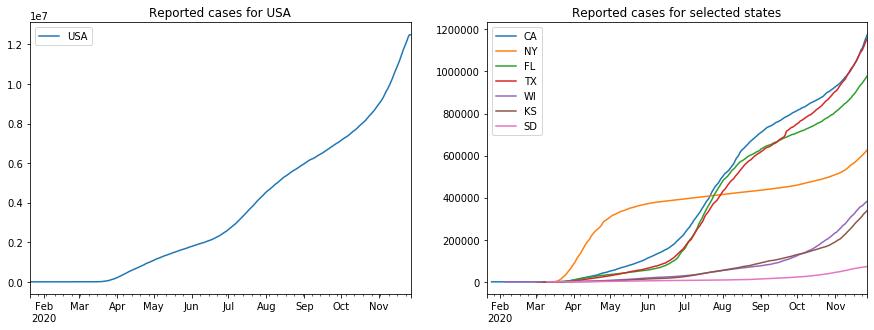

In [56]:
# now do some quick plots using plot method of dataframe.  Save the figures out to pdf
figure, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
dat_sample1.plot(ax=axes[0],title = "Reported cases for USA")
dat_sample2.plot(ax= axes[1],title = "Reported cases for selected states")

In [57]:
# This is a different way of formatting strings called f-strings. Supported in later versions of Python
figure.suptitle(f'Data = total cases reported',fontsize = 15)
plt.savefig("out_3.1_Cases_"+REGION+"+selected.pdf")   # could also save as .gif, .png, .jpeg ....

<Figure size 432x288 with 0 Axes>

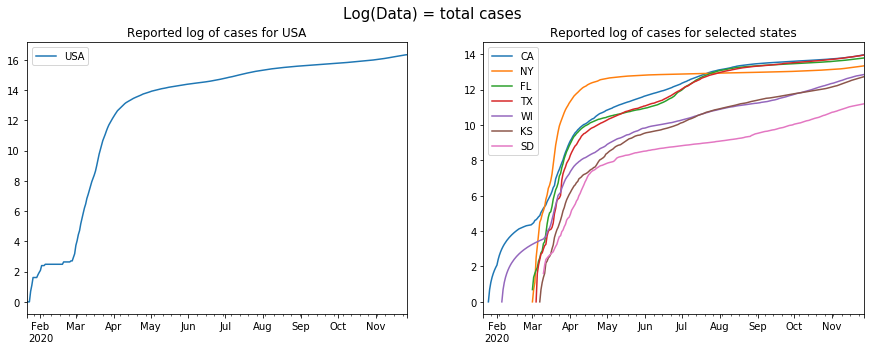

In [58]:
figure, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
np.log(dat_sample1).plot(ax = axes[0],title = "Reported log of cases for USA")
np.log(dat_sample2).plot(ax = axes[1],title = "Reported log of cases for selected states")
figure.suptitle(f'Log(Data) = total cases',fontsize = 15)
plt.savefig("out_3.1_logCases_"+REGION+"+selected.pdf")   # could also save as .gif, .png, .jpeg ....

### 3.2 select portion of data to start plotting from i.e. after specified number of cases recorded

In [59]:
# Get the max cases for the region
max_cases = np.max(dat[REGION])
if TRACE: display(max_cases)

12485385.0

In [60]:
# select data that starts at CASE_STARTS only if CASE_STARTS is less than max_cases observed otherwise start at 1000
if (max_cases < CASE_STARTS):
    CASE_STARTS = 1_000
start_cases = dat[REGION][dat[REGION] >= CASE_STARTS].index[0]
start_cases_str = start_cases.strftime("%d-%b-%Y")  # note that date at which data starts

In [61]:
# Note how many data points were discarded
discard = len(dat.loc[:start_cases])-1
if TRACE: display(discard)

272

In [62]:
# show the data series we will use to fit the model
if TRACE: display(dat.loc[start_cases:,REGION])

2020-10-19     8036253.0
2020-10-20     8092187.0
2020-10-21     8152149.0
2020-10-22     8221451.0
2020-10-23     8298508.0
2020-10-24     8377398.0
2020-10-25     8439683.0
2020-10-26     8502621.0
2020-10-27     8572273.0
2020-10-28     8647878.0
2020-10-29     8734776.0
2020-10-30     8823999.0
2020-10-31     8914806.0
2020-11-01     8987032.0
2020-11-02     9068682.0
2020-11-03     9154043.0
2020-11-04     9254499.0
2020-11-05     9367997.0
2020-11-06     9499081.0
2020-11-07     9627627.0
2020-11-08     9730071.0
2020-11-09     9849896.0
2020-11-10     9978668.0
2020-11-11    10117899.0
2020-11-12    10267371.0
2020-11-13    10434221.0
2020-11-14    10593946.0
2020-11-15    10732177.0
2020-11-16    10881124.0
2020-11-17    11035624.0
2020-11-18    11192629.0
2020-11-19    11370789.0
2020-11-20    11558389.0
2020-11-21    11729370.0
2020-11-22    11873233.0
2020-11-23    12030751.0
2020-11-24    12189073.0
2020-11-25    12367098.0
2020-11-26    12485385.0
2020-11-27    12485385.0


In [63]:
# Now take the series and convert it into a tuple for the models.  Adjust by the under reporting factor
Infected = tuple(dat.loc[start_cases:,REGION].dropna()*UNDER_REPORT_FACTOR)[:]
if TRACE: display(Infected)

(8036253.0,
 8092187.0,
 8152149.0,
 8221451.0,
 8298508.0,
 8377398.0,
 8439683.0,
 8502621.0,
 8572273.0,
 8647878.0,
 8734776.0,
 8823999.0,
 8914806.0,
 8987032.0,
 9068682.0,
 9154043.0,
 9254499.0,
 9367997.0,
 9499081.0,
 9627627.0,
 9730071.0,
 9849896.0,
 9978668.0,
 10117899.0,
 10267371.0,
 10434221.0,
 10593946.0,
 10732177.0,
 10881124.0,
 11035624.0,
 11192629.0,
 11370789.0,
 11558389.0,
 11729370.0,
 11873233.0,
 12030751.0,
 12189073.0,
 12367098.0,
 12485385.0,
 12485385.0)

In [64]:
# Display the Region
if TRACE: display(REGION)

'USA'

### 3.3 plot cases and log of cases of Region to see how cases as growing - customize chart

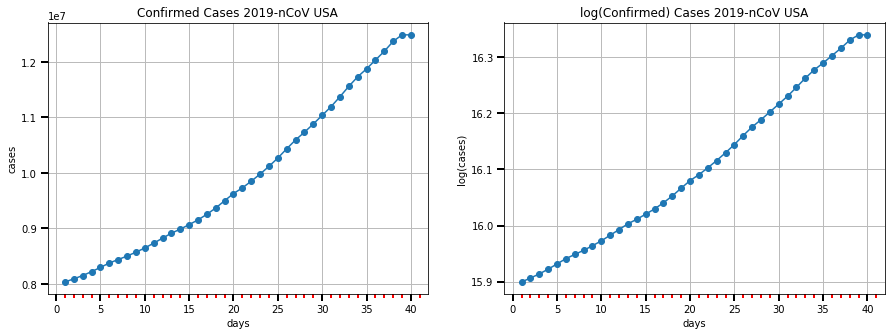

<Figure size 432x288 with 0 Axes>

In [65]:
from matplotlib.ticker import AutoMinorLocator  # to set minor tick marks

# Plot the wikipedia daily case data 
Day = list(range(1,len(Infected)+1))

# Plot untransformed cumulative case data
figure, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axes[0].plot(Day,Infected,marker = "o")
axes[0].set_title("Confirmed Cases 2019-nCoV "+REGION)
axes[0].set_xlabel("days")
axes[0].set_ylabel("cases")
axes[0].grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')

axes[0].xaxis.set_minor_locator(AutoMinorLocator()) 
axes[0].tick_params(which='both', width=2)
axes[0].tick_params(which='major', length=7)
axes[0].tick_params(which='minor', length=4, color='r')

# Plot using log scale to show log-linear growth 
axes[1].plot(Day,np.log(Infected),marker="o")
axes[1].set_title("log(Confirmed) Cases 2019-nCoV "+REGION)
axes[1].set_xlabel("days")
axes[1].set_ylabel("log(cases)")
axes[1].grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')

axes[1].xaxis.set_minor_locator(AutoMinorLocator())
axes[1].tick_params(which='both', width=2)
axes[1].tick_params(which='major', length=7)
axes[1].tick_params(which='minor', length=4, color='r')
plt.show()
plt.savefig("out_3.3_Hist_Cases_"+REGION+".pdf")   # could also save as .gif, .png, .jpeg ....

### 3.4 plot all states as small multiples on the US map 8x11 grid

See if we can plot the growth curve for all states on the "US Grid" according to coordinate. This will allow us 
to quickly compare every state.

In [66]:
# Do for only the states - need to remove "New" and "USA" from our dataframe columns.  Use a set difference 
# to select only state columns
stat1 = "CumCases"
states = dat.columns
states = set(states)-set(["New","USA"])

In [67]:
len(Day)

40

In [68]:
# Plot the wikipedia daily case data 
use_log = False
if use_log:
    stat1 = "log of cumulative cases"
else:
    stat1 = "Cumulative cases"

### NOTE: This cell may take a minute or more to run - 51 graphs are being plotted here

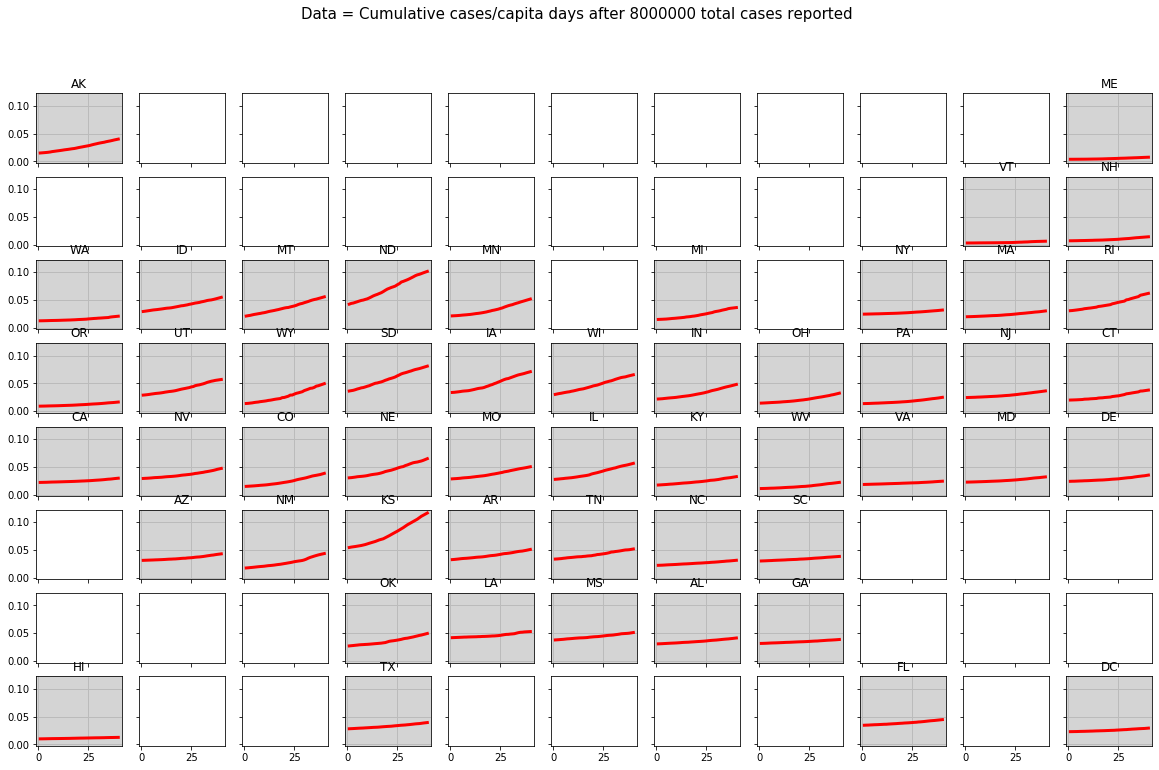

In [69]:
# Now map the case history onto the US map grid
from matplotlib.ticker import AutoMinorLocator  # to set minor tick marks

fig, axes = plt.subplots(nrows=8, ncols=11,sharex=True,sharey=True,figsize = (20,12))

for state in states:
    
    # get the state population
    st_pop = st_info_df[st_info_df.PostCode==state].Pop.values
    
    # calculate per capita infected
    Infctd = tuple(dat.loc[start_cases:,state].dropna()*UNDER_REPORT_FACTOR/st_pop)[:]
    Day = list(range(1,len(Infctd)+1))
    ax0 = int(usplotgrid_df.loc[state].loc["ax0"])
    ax1 = int(usplotgrid_df.loc[state].loc["ax1"])
    
    # Plot using log scale to show log-linear growth 
    if use_log:
        axes[ax0,ax1].plot(Day,np.log(Infctd),lw=3, ls='-',color = "red")
    else:
        axes[ax0,ax1].plot(Day,Infctd,lw=3, ls='-',color = "red")
    
    axes[ax0,ax1].set_title(state)
    axes[ax0,ax1].grid(b=True, which='both', c='#bbbbbb', lw=1, ls='-')
    axes[ax0,ax1].set_facecolor('#D4D4D4')   # Hex for grey - see web for hex for other colors
    axes[7,3]
    
    #plt.show()
    
plt.plot(wspace=0.5, hspace=0.5)
# set up superior title for the chart
fig.suptitle(f'Data = {stat1}/capita days after {CASE_STARTS} total cases reported',fontsize = 15)

# save the output into a pdf file
if use_log:
    plt.savefig("out_3.4_logCases_"+REGION+".pdf")   # could also save as .gif, .png, .jpeg ....
else:
    plt.savefig("out_3.4_Cases_"+REGION+"_ALL.pdf")            

<pre>_____________________________________________________________________________________________________</pre>

<a id='Slope'></a>
# 4. Calculate change in slope of the exponential curve

**Now calculate the slope and change of slope of the log curve to detect rate of change, and whether rate of change in decelerating (calculate the slope numerically)**

[TOC](#TOC)

## **Our to do list:**

_4. Calculate slope of exponential curve:_

- **Task 4.1**: Put log infected data into a dataframe so we can use the `.diff()` method in pandas
- **Task 4.2**: Plot the slope and change in slope curves for the Region specified
- **Task 4.3**: Plot change is slope of curve for all states as small multiples on the US map 8x11 grid

### Methods to use:
* `pd.DataFrame()`     - create data frame from list or array data
* `.diff()`            - calculate the nth difference between entries in a dataframe column
* `.rolling().mean()`  - calculate the rolling or moving average on data accoring to a specified window e.g. 7 days
* `df.plot(ax=axes[i],marker="o", title = "Log of cases")` - plot method of dataframe, with graph on different axes

### 4.1 Put log infected data into a dataframe so we can use the .diff() method in pandas

In [70]:
slope = pd.DataFrame(np.log(Infected),columns=["logI"])

In [71]:
# Calculate the slope daily and a 7 day rolling average window to show the trend
# Remember slope is (y2-y1)/(x2-x1) or "rise" over "run". Our x2-x1 = delta_t which is daily change in our case
# To approximate the curvature or 2nd derivative do the difference on the 1st derivative column and divide by delta_t
delta_t         = 1  
slope["IChg"]   = slope['logI'].diff(delta_t)            # daily change
slope["Idt"]    = (slope.IChg)/delta_t                   # daily change/change in time = slope = 1st derivative
slope["Idt2"]   = slope.Idt.diff(delta_t)/delta_t        # change in daily change/change in time = 2nd derivative
slope["IdtMA"]  = slope['Idt'].rolling(window=7).mean()  # 7 day moving average of slope
slope["Idt2MA"] = slope["Idt2"].rolling(window=7).mean() # 7 day moving average of change in slope 

In [72]:
# inspect
if TRACE: display(slope.head(10))

,logI,IChg,Idt,Idt2,IdtMA,Idt2MA
0,15.899473,NaN,NaN,NaN,NaN,NaN
1,15.906410,0.006936,0.006936,NaN,NaN,NaN
2,15.913792,0.007383,0.007383,0.000446,NaN,NaN
3,15.922257,0.008465,0.008465,0.001083,NaN,NaN
4,15.931586,0.009329,0.009329,0.000864,NaN,NaN
5,15.941048,0.009462,0.009462,0.000133,NaN,NaN
6,15.948455,0.007407,0.007407,-0.002054,NaN,NaN
7,15.955885,0.007430,0.007430,0.000022,0.008059,NaN
8,15.964043,0.008158,0.008158,0.000729,0.008233,0.000175
9,15.972825,0.008781,0.008781,0.000623,0.008433,0.000200


### 4.2 Plot the slope and change in slope curves for the Region specified

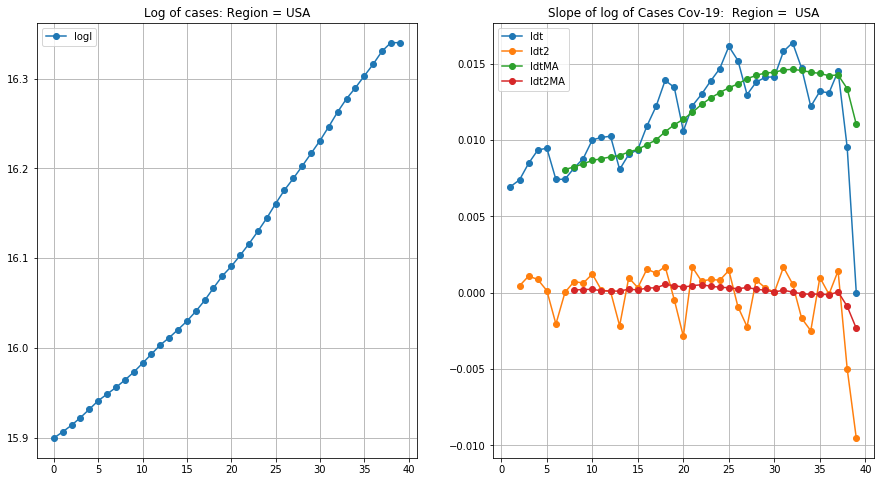

In [73]:
figure, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(15,8))

slope.loc[:,["logI"]].plot(ax=axes[0],marker="o", title = "Log of cases: Region = "+REGION)
axes[0].grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')

ax = slope.loc[:,["Idt","Idt2","IdtMA","Idt2MA"]].plot(ax=axes[1],marker="o")
ax.grid('on', which='major', axis='x' )
ax.grid('on', which='major', axis='y' )
ax.set_title("Slope of log of Cases Cov-19:  Region =  "+REGION)
plt.savefig("out_4.1_Slope_"+REGION+".pdf")

### 4.3 plot change is slope of curve fora all states as small multiples on the US map 8x11 grid

In [74]:
if TRACE: display(slope.tail(10))

,logI,IChg,Idt,Idt2,IdtMA,Idt2MA
30,16.230766,0.014127,0.014127,0.000028,0.014421,0.000039
31,16.246558,0.015792,0.015792,0.001665,0.014582,0.000161
32,16.262922,0.016364,0.016364,0.000572,0.014617,0.000035
33,16.277607,0.014684,0.014684,-0.001679,0.014545,-0.000072
34,16.289797,0.012191,0.012191,-0.002494,0.014434,-0.000110
35,16.302977,0.013179,0.013179,0.000989,0.014348,-0.000086
36,16.316050,0.013074,0.013074,-0.000105,0.014202,-0.000146
37,16.330550,0.014500,0.014500,0.001426,0.014255,0.000053
38,16.340069,0.009519,0.009519,-0.004980,0.013359,-0.000896
39,16.340069,0.000000,0.000000,-0.009519,0.011021,-0.002338


In [75]:
# Plot the wikipedia daily case data 
# set up lookup dictionary of metric to df column and % threshold to plot on graphs
stat_dict = {"Slope":["Idt",0.1],"Slope MA(7)":["IdtMA",0.05],"Chg of Slope":["Idt2",0.0], \
             "Chg of Slope MA(7)":["Idt2MA",0.00]}
# select stat to plot
stat1 = "Slope MA(7)"
#stat1 = "Chg of Slope MA(7)"
curve = stat_dict[stat1][0]
thresh = stat_dict[stat1][1]
display(curve)
display(thresh)

'IdtMA'

0.05

<pre>_____________________________________________________________________________________________________</pre>

### NOTE: This cell may take a minute or more to run - 51 graphs are being plotted here

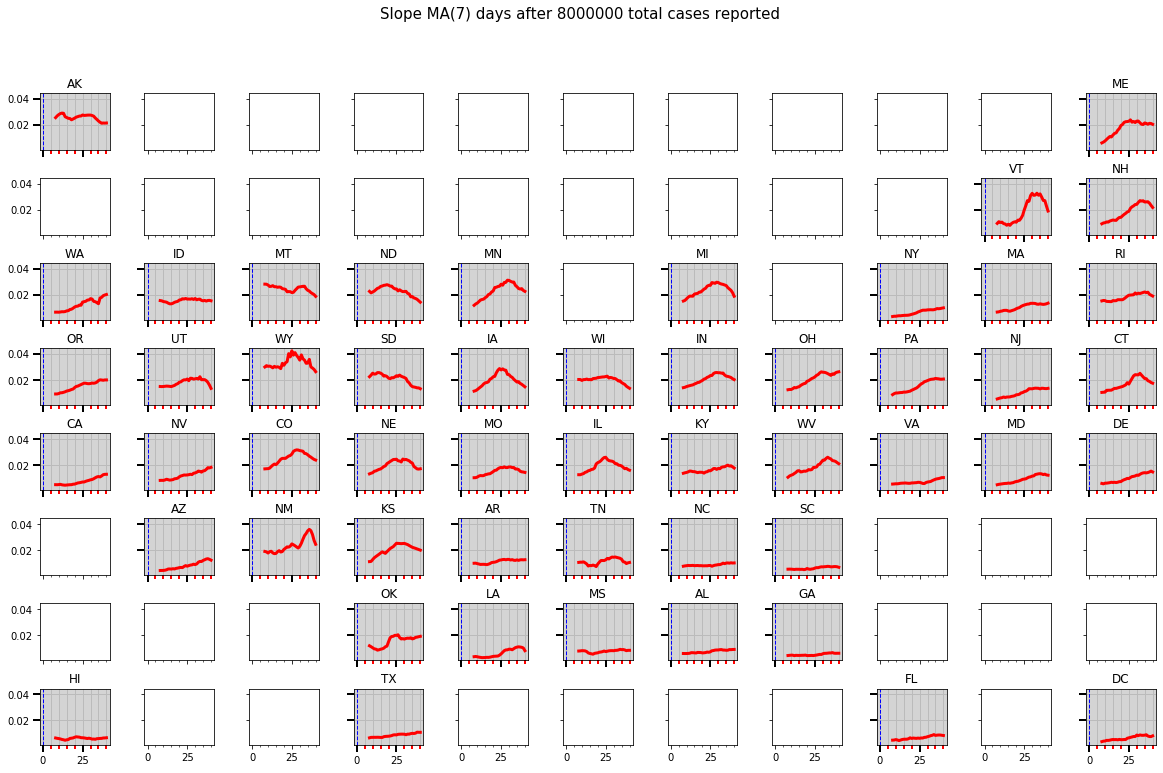

<Figure size 432x288 with 0 Axes>

In [76]:
# plot the data on US map grid
#import warnings                   #<--- use this to suppress deprecation warnings from matplotlib
#warnings.filterwarnings("ignore")

from matplotlib.ticker import AutoMinorLocator  # to set minor tick marks
fig, axes = plt.subplots(nrows=8, ncols=11,sharex=True,sharey=True,figsize = (20,12))

for state in states:
    Infctd = tuple(dat.loc[start_cases:,state].dropna()*UNDER_REPORT_FACTOR)[:]
    Day = list(range(1,len(Infctd)+1))
    slope = pd.DataFrame(np.log(Infctd),columns=["logI"])

    # Calculate the slope daily and a 7 day rolling average window to show the trend
    # You did this already in 4.1
    delta_t         = 1  
    slope["IChg"]   = slope['logI'].diff(delta_t)
    slope["Idt"]    = (slope.IChg)/delta_t
    slope["Idt2"]   = slope.Idt.diff(delta_t)/delta_t
    slope["IdtMA"]  = slope['Idt'].rolling(window=7).mean()
    slope["Idt2MA"] = slope['Idt2'].rolling(window=7).mean()
    
    ax0 = int(usplotgrid_df.loc[state].loc['ax0'])
    ax1 = int(usplotgrid_df.loc[state].loc['ax1'])
    
    #IdtMA = slope.loc[:,["IdtMA"]]
    line = slope.loc[:,curve]
    
    axes[ax0,ax1].plot(Day,line,lw=3, ls='-',color = "red")
    axes[ax0,ax1].set_title(state)
    axes[ax0,ax1].grid(b=True, which='both', c='#bbbbbb', lw=1, ls='-')
    axes[ax0,ax1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[ax0,ax1].tick_params(which='both', width=2)
    axes[ax0,ax1].tick_params(which='major', length=7)
    axes[ax0,ax1].tick_params(which='minor', length=4, color='r')
    axes[ax0,ax1].set_facecolor('#D4D4D4')
    axes[ax0,ax1].axvline(thresh, color="blue", linestyle="--",lw=1)  # axhline - horizontal line

# adust spacing between graphs and set up a main title for figure
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle(f'{stat1} days after {CASE_STARTS} total cases reported',fontsize = 15)
plt.show()
plt.savefig("out_4.3_"+curve+"_ALL.pdf")

<pre>_____________________________________________________________________________________________________</pre>

<a id='ModelFitting'></a>
# 5. Fit Model

**Now start fitting model for beta and gamma to the data**

[TOC](#TOC)

## **Our to do list:**

_5. Fit model:_
- **Task 5.1**: set up initial conditions for model
- **Task 5.2**: Set up the SIR model function as per the formulas
- **Task 5.3**: set up the odeint_chg_beta() function that does the numerical integration (i.e. solving) of the SIR equations
- **Task 5.4**: set up a function to calculate the Residual Sum of Squares between SIR model and observed data
- **Task 5.5**: do a least squares fit on RSS to get Beta and Gamma that minimizes the RSS


### Methods to use:
* `np.linspace()`  - set up array of equally spaced data points
* `from scipy.optimize import least_squares` - scipy optimization library least_squares optimizer
* `.T`   - transpose matrix

### 5.1 set up initial conditions for model

In [77]:
# Global inputs - Use Named constants
REGION              =  "USA"
UNDER_REPORT_FACTOR =  1                        # multiply number of cases by this amount to account for underreporting

CASE_STARTS         =  8_000_000                # fit curves to data starting at these number of cases
RECOVERIES          =  int(CASE_STARTS*0.5)     # Set initial condition for recoveries (model not sensitive to this)

TRACE               = True                      # General debug flag for printing output
TRACE_BETA          = True                      # Debug flag for printing output of changed beta scenarios

### 5.2 select portion of data to start plotting from i.e. after specified number of cases recorded

**NOTE:** We are going to repeat the steps for selecting infected data to use so we can fit them model to portion of dataset after CASE_STARTS. This will let us get a better estimate of the current Beta and Gamma for recent data. 

In [78]:
# Get the max cases for the region
max_cases = np.max(dat[REGION])
if TRACE: display(max_cases)

12485385.0

In [79]:
# select data that starts at CASE_STARTS only if CASE_STARTS is less than max_cases observed otherwise start at 1000
if (max_cases < CASE_STARTS):
    CASE_STARTS = 1000
start_cases = dat[REGION][dat[REGION] >= CASE_STARTS].index[0]
start_cases_str = start_cases.strftime("%d-%b-%Y")  # note that date at which data starts

In [80]:
start_cases

Timestamp('2020-10-19 00:00:00', freq='D')

In [81]:
# Note how many data points were discarded
discard = len(dat.loc[:start_cases])-1
if TRACE: display(discard)

272

In [82]:
# show the data series we will use to fit the model
if TRACE: display(dat.loc[start_cases:,REGION])

2020-10-19     8036253.0
2020-10-20     8092187.0
2020-10-21     8152149.0
2020-10-22     8221451.0
2020-10-23     8298508.0
2020-10-24     8377398.0
2020-10-25     8439683.0
2020-10-26     8502621.0
2020-10-27     8572273.0
2020-10-28     8647878.0
2020-10-29     8734776.0
2020-10-30     8823999.0
2020-10-31     8914806.0
2020-11-01     8987032.0
2020-11-02     9068682.0
2020-11-03     9154043.0
2020-11-04     9254499.0
2020-11-05     9367997.0
2020-11-06     9499081.0
2020-11-07     9627627.0
2020-11-08     9730071.0
2020-11-09     9849896.0
2020-11-10     9978668.0
2020-11-11    10117899.0
2020-11-12    10267371.0
2020-11-13    10434221.0
2020-11-14    10593946.0
2020-11-15    10732177.0
2020-11-16    10881124.0
2020-11-17    11035624.0
2020-11-18    11192629.0
2020-11-19    11370789.0
2020-11-20    11558389.0
2020-11-21    11729370.0
2020-11-22    11873233.0
2020-11-23    12030751.0
2020-11-24    12189073.0
2020-11-25    12367098.0
2020-11-26    12485385.0
2020-11-27    12485385.0


In [83]:
# Now take the series and convert it into a tuple for the models.  Adjust by the under reporting factor
Infected = tuple(dat.loc[start_cases:,REGION].dropna()*UNDER_REPORT_FACTOR)[:]
if TRACE: display(Infected)

(8036253.0,
 8092187.0,
 8152149.0,
 8221451.0,
 8298508.0,
 8377398.0,
 8439683.0,
 8502621.0,
 8572273.0,
 8647878.0,
 8734776.0,
 8823999.0,
 8914806.0,
 8987032.0,
 9068682.0,
 9154043.0,
 9254499.0,
 9367997.0,
 9499081.0,
 9627627.0,
 9730071.0,
 9849896.0,
 9978668.0,
 10117899.0,
 10267371.0,
 10434221.0,
 10593946.0,
 10732177.0,
 10881124.0,
 11035624.0,
 11192629.0,
 11370789.0,
 11558389.0,
 11729370.0,
 11873233.0,
 12030751.0,
 12189073.0,
 12367098.0,
 12485385.0,
 12485385.0)

In [84]:
# Display the Region
if TRACE: display(REGION)

'USA'

In [85]:
# get the total population
if REGION == "USA":
    N = 330_000_000
else:
    N = st_info_df[st_info_df["PostCode"]==REGION].Pop.iloc[0]
if TRACE: display(N)

330000000

In [86]:
# initial infected
I0 = Infected[0]
# initial recovered
#R0 = 1
R0 = RECOVERIES
#initial susceptible
S0 = N - I0 - R0
(S0,I0,R0)

(317963747.0, 8036253.0, 4000000)

We need to assign values for $\beta$ and $\gamma$. We’ll optimize the model for the best $\beta$ and $\gamma$.

Now, let’s build our initial conditions vector,  and then use linspace to create an array containing our sampling points (days).

In [87]:
# initial conditions vector
y0 = (S0, I0, R0)
# evenly spaced values (representing days)
t = np.linspace(1, 100, 100)

Here's the SIR differential equation model again

### 5.2 Set up the SIR model function as per the formulas

In [88]:
def SIR(y, t, N, beta, gamma):
    # S, I, R values assigned from vector
    S, I, R = y
    # differential equations
    dSdt = -beta * S * I / N
    dIdt =  beta * S * I / N - gamma * I
    dRdt =  gamma * I
    return dSdt, dIdt, dRdt

Let's create a residual sum of squares function RSS that minimizes the RSS between the SIR model and the observed data wrt to $\beta$ and $\gamma$.

We will use minimize and least_squares from the scipy.optimize library.  

First we need a function to numerically integrate the SIR differential equation daily starting with the initial conditions

### 5.3 set up the odeint_chg_beta() function that does the numerical integration (i.e. solving) of the SIR equations

We are going to make a modification to the function we created previously to allow us to change beta after a period
of time. We are going to pass in a parameter called `chgBeta as a tuple.`

- `chgBeta[0] = True or False`
- `chgBeta[1] = integer` with number of days after start of projection at which we will change Beta
- `chgBeta[2] = float` indicating how Beta will change from beta_0 e.g. x2 

- simple model. Allows change of beta at days after start by multiplier - e.g. after 30 days stop social distancing and beta changes by the multiplier e.g. x2. 

So ```chgBeta = (True,0,2)``` indicates that Beta will change 0 days (i.e. right away) by factor of x2.  We can use this to simulate what happens if social distancing stops and Beta increases by factor given.

In [89]:
# function to integrate SIR model from starting conditions but with ability to change beta over time

# The chgBeta tuple is used to change beta during the scenario.
#     chgBeta[0] = False if no change in beta, else beta will change during projection
#     chgBeta[1] = days after to change beta
#     chgBeta[2] = beta multiplier

def odeint_chg_beta(y0,t,N,beta_0,gamma,chgBeta=(False,0,1),Trace = False):
    #import pdb;pdb.set_trace(); chgBeta = (True,0,0.5,1)
    y = y0
    values      = np.zeros((len(t),3)) 
    values[0,0] = y0[0]   # S0
    values[0,1] = y0[1]   # I0
    values[0,2] = y0[2]   # R0
    beta        = beta_0
   
    for i in range(1,len(t)):
        dSt, dIt, dRt = SIR(y,i,N,beta,gamma)
        values[i,0]   = values[i-1,0] + dSt
        values[i,1]   = values[i-1,1] + dIt
        values[i,2]   = values[i-1,2] + dRt
        y             = (values[i,0],values[i,1],values[i,2])
        
        # If change beta, simple change in beta at a specified point in time    
        if chgBeta[0]:                   # change beta = True
            if i > chgBeta[1]:           # point in time at which to change beta
                beta = beta_0*chgBeta[2] # change beta by multiplier passed in

        if Trace and (i<60): print("i: ",format(i,'3d'),"beta: ",format(beta,'4.2f'),"gamma: ",format(gamma,'4.2f'),
                                   "R0: ",format(beta/gamma,'4.2f'),
                                   "S/N: ",format(values[i,0]/N,'5.2f'),
                                   "Inf: ",format(values[i,1],'16,.2f'),"dIt: ",format(dIt,'10,.2f'))
                                                
    return values

This is the residual sum of squares function used to by the least squares optimizer to fit beta and gamma.

### 5.4 Set up a function to calculate the Residual Sum of Squares between SIR model and observed data

In [90]:
import numpy as np
from scipy.optimize import minimize,least_squares

# python optimization function
def RSS(x,y0,t,N,Infected,Trace):

    #import pdb;pdb.set_trace()
    # Integrate the diff eqs over the time array
    out = odeint_chg_beta(y0, t, N, x[0], x[1],chgBeta=(False,0,1),Trace=Trace)

    # assign S, I, R values from values transpose
    S, I, R = out.T
    
    rss = np.sum((np.array(I)-np.array(Infected))**2)
    return rss

# contact rate
beta = 0.3
# mean recovery rate
gamma = 0.1

RSS([beta,gamma],y0,t[0:len(Infected)],N,Infected,Trace=False)

1.4859693027543725e+17

### 5.5 Do a least squares fit on RSS to get Beta and Gamma that minimizes the RSS

In [91]:
# using least squares
sub_t = t[0:len(Infected)]
ropt = least_squares(fun=RSS,
                args=(y0,sub_t,N,Infected,False),
                x0 = (0.5,0.5))      # <- initial guess

print(ropt)

 active_mask: array([0., 0.])
        cost: 4.166056472949542e+27
         fun: array([9.12804083e+13])
        grad: array([ 1.48910382e+29, -2.51201651e+28])
         jac: array([[ 1.63135096e+15, -2.75197773e+14]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 200
        njev: 197
  optimality: 1.4891038171023004e+29
      status: 0
     success: False
           x: array([0.22856218, 0.18979601])


<a id='BaseCase'></a>
# 6. Base Case - Beta as per model fit
[TOC](#TOC)

## **Our to do list:**

_6. Base Case - Beta as per model fit:_
- **Task 6.1**: Set up variables and assumptions
- **Task 6.2**: Project the spread of the epidemic based on SIR model and best Beta & Gamma fit to data
- **Task 6.3**: Plot SIR data and projections
- **Task 6.4**: Report summary data from SIR model

### Methods to use:
* `.T`            - Transpose
* `.argmax()`     - locate maximum in a dataframe column
* `pd.to_excel()` - write data out to excel file

<br>

The plot methods we have seen before and some new ones to customize the graph look:
* `plt.subplots()`,`.plot()`,`.set_title()`, `.set_xlabel()`,`.set_ylabel()`,`.grid()`
* `.xaxis.set_minor_locator(AutoMinorLocator())` 
* `.tick_params()`
* `.axhline()`             - draw horizontal line on graph at specified location
* `.set_facecolor()`       - set the face color of a graph
* `.subplots_adjust()`     - we will use to adjust whitespace between small graphs
* `.suptitle()`            - super title for figure
*  `plt.savefig()`         - save out the figure to a file

### 6.1 Set up variables and assumptions

In [92]:
# Global inputs - Use Named constants
REGION              =  "USA"
UNDER_REPORT_FACTOR =  1                        # multiply number of cases by this amount to account for underreporting
START_DAY           =  0                        # start day for beta change from today less than or equal 0
DELAY_DAYS          =  len(Infected)            # number days after data start for beta to change               
BETA_PCT            =  1.5                      # fraction by which beta changes from beta0 after delay days

HOSP_CAP_FACTOR     = .25                       # % of hospital beds that can be allocated to Covid-19
HOSP_RATE           = 0.15/UNDER_REPORT_FACTOR  # % of infected that need hospitalization
MORT                = 0.005/UNDER_REPORT_FACTOR # assumed mortality rate
HOSP_DAYS           = 7                         # Number of days infected hospitalized are in Hospital
TRACE               = False                     # General debug flag for printing output
TRACE_BETA          = True                      # Debug flag for printing output of changed beta scenarios

In [93]:
# set population by region
hbf  = 2.8/1000  # Estimate of hospital beds = 28 per 1000 of population

### 6.2 Project the spread of the epidemic based on SIR model and best Beta & Gamma fit to data

In [94]:
# Integrate the diff eqs over the time array using the best fit beta and data for recent data
beta = ropt["x"][0]
gamma = ropt["x"][1]

#chgBeta = (False,0,1,2)
chgBeta = (True,DELAY_DAYS,BETA_PCT)

# Set the Trace to true so we can see output of model by day
values = odeint_chg_beta(y0, t, N, beta, gamma,chgBeta,Trace=True)

# assign S, I, R values from values transpose
S, I, R = values.T

i:    1 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.96 Inf:      8,280,793.80 dIt:  244,540.80
i:    2 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.95 Inf:      8,522,625.48 dIt:  241,831.68
i:    3 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.95 Inf:      8,760,814.77 dIt:  238,189.29
i:    4 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.94 Inf:      8,994,400.53 dIt:  233,585.76
i:    5 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.94 Inf:      9,222,400.69 dIt:  228,000.16
i:    6 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.93 Inf:      9,443,819.90 dIt:  221,419.21
i:    7 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.92 Inf:      9,657,657.80 dIt:  213,837.90
i:    8 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.92 Inf:      9,862,917.91 dIt:  205,260.11
i:    9 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.91 Inf:     10,058,616.92 dIt:  195,699.01
i:   10 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   0.90 Inf:     10,243,794.28 dIt:  185,177.36
i:   11 beta:  0.23 gamma:  0.19 R0:  1.20 S/N:   

Finally, we can plot the arrays using matplotlib:

### 6.3 Plot SIR data and projections

In [95]:
# get the hospital bed estimate for the Region
if REGION == "USA":
    hosp_beds = 950_000
else:
    hosp_beds = st_info_df[st_info_df["PostCode"]==REGION].HospBeds.iloc[0]
hosp_beds

950000

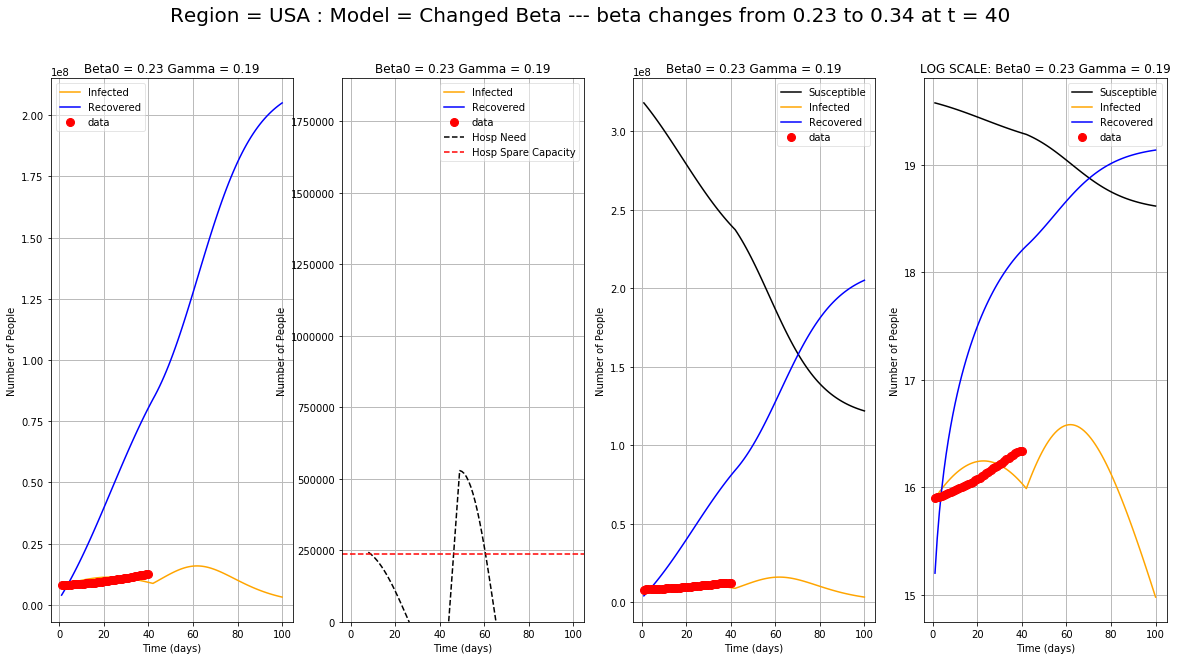

In [96]:
# plot 4 charts:
# 1.  Infected data, Infected fcst, Recovered fcst zoom-in
# 2.  Infected data, Infected fcst, Recovered fcst, hosp bed capacity, hosp bed fcst zoom-in
# 3.  Infected data, Infected fcst, Recovered fcst, Suceptible fcast - no zoom-in
# 4.  log of Infected data, Infected fcst, Recovered fcst, Suceptible fcast - no zoom-in

add_days = 60                          # project 60 days out for the zoom in chart
dat_days = len(Infected)
k = len(Infected)+add_days

# Creates two subplots and unpacks the output array immediately
fig, (ax1,ax0,ax2,ax3) = plt.subplots(1, 4,figsize=(20, 10))

# Plot 1:
# Estimate number of people in hospital - last 14 days of infections need hospital at rate HOSP_RATE
H = np.array(pd.Series(I[:k]).diff().rolling(HOSP_DAYS).sum()*HOSP_RATE)

ax0.plot(t[:k], I[:k], 'orange', lw=1.5, label='Infected')
ax0.plot(t[:k], R[:k], 'blue', lw=1.5, label='Recovered')
ax0.plot(sub_t[:dat_days],Infected[:dat_days],'or',markersize=8,label = 'data')
ax0.plot(t[:k], H[:k], 'k--', lw=1.5, label='Hosp Need')
ax0.set_xlabel('Time (days)')
ax0.set_ylabel('Number of People')
ax0.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
ax0.set_title("Beta0 = "+format(beta,'.2f')+" Gamma = "+format(gamma,'.2f'))
ax0.axhline(hosp_beds*HOSP_CAP_FACTOR, color="red", linestyle="--",label="Hosp Spare Capacity")
ax0.set_ylim(0,hosp_beds*HOSP_CAP_FACTOR*8)
legend = ax0.legend()
legend.get_frame().set_alpha(0.5)

# Plot 2:
ax1.plot(t[:k], I[:k], 'orange', lw=1.5, label='Infected')
ax1.plot(t[:k], R[:k], 'blue', lw=1.5, label='Recovered')
ax1.plot(sub_t[:dat_days],Infected[:dat_days],'or',markersize=8,label = 'data')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Number of People')
ax1.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
ax1.set_title("Beta0 = "+format(beta,'.2f')+" Gamma = "+format(gamma,'.2f'))
legend = ax1.legend()
legend.get_frame().set_alpha(0.5)

#Plot 3:
ax2.plot(t, S, 'black', lw=1.5, label='Susceptible')
ax2.plot(t, I, 'orange', lw=1.5, label='Infected')
ax2.plot(t, R, 'blue', lw=1.5, label='Recovered')
ax2.plot(sub_t,Infected[:dat_days],'or',markersize=8,label = 'data')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Number of People')
ax2.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
legend = ax2.legend()
legend.get_frame().set_alpha(0.5)
ax2.set_title("Beta0 = "+format(beta,'.2f')+" Gamma = "+format(gamma,'.2f'))

#Plot 4:
ax3.plot(t, np.log(S), 'black', lw=1.5, label='Susceptible')
ax3.plot(t, np.log(I), 'orange', lw=1.5, label='Infected')
ax3.plot(t, np.log(R), 'blue', lw=1.5, label='Recovered')
ax3.plot(sub_t,np.log(Infected),'or',markersize=8,label = 'data')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Number of People')
ax3.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
legend = ax3.legend()
legend.get_frame().set_alpha(0.5)
ax3.set_title("LOG SCALE: Beta0 = "+format(beta,'.2f')+" Gamma = "+format(gamma,'.2f'))

fig.suptitle(f'Region = {REGION} : Model = Changed Beta --- beta changes from {beta:.2f} to {beta*chgBeta[2]:.2f} at t = {chgBeta[1]}',fontsize = 20)

#plt.show()
plt.savefig("out_6.3_BaseCase_"+REGION+".pdf")

We see in the right log-linear plot that the model does not seems to fit the values too well. This may be because we are using USA as a whole and the spread is currently too uneven to be modeled by one SIR model. We will assume that the model is directionaly right. 

We can now extract some interesting statistics. One important number is the so-called basic reproduction number (also basic reproduction ratio) (pronounced “R naught”) which basically shows how many healthy people get infected by a sick person on average:

In [97]:
# summarize some of the statistics
R0 = beta/gamma   
pk = np.argmax(I)

print(f'Region = {REGION} : Model = Changed Beta --- beta changes from {beta:.2f} to {beta*chgBeta[2]:.2f} at t = {chgBeta[1]}')
print("    RO   = ",format(R0,'0.2f'))
RNEW = beta*chgBeta[2]/gamma 
print("    RNew = ",format(RNEW,'0.2f'))

print("    Under Report Factor = ",UNDER_REPORT_FACTOR)
print("    Reference date = ",start_cases_str)
print("    Days to Peak Infection = ",pk)
print("    Remaining days to peak infection = ",pk -len(sub_t))
print("    Peak Infected = ", format(I[pk],",.0f")," or ",format(I[pk]/N,".2%"),"of population")
print("    Peak Recovered (Immune + Dead) = ", format(R[-1],",.0f"), "or ",format(R[-1]/N,",.0%"),"of population")
print("    Deaths = ",format(R[-1] * MORT,',.0f'),"at mortality rate of ",format(MORT,".2%"))   
#print("    Deaths = ",format(np.sum(I) * MORT,',.0f'),"at mortality rate of ",format(MORT,".2%"))  

Region = USA : Model = Changed Beta --- beta changes from 0.23 to 0.34 at t = 40
    RO   =  1.20
    RNew =  1.81
    Under Report Factor =  1
    Reference date =  19-Oct-2020
    Days to Peak Infection =  61
    Remaining days to peak infection =  21
    Peak Infected =  15,930,491  or  4.83% of population
    Peak Recovered (Immune + Dead) =  205,011,323 or  62% of population
    Deaths =  1,025,057 at mortality rate of  0.50%


# Conclusion ?
**If you run the model assuming that beta does not change i.e. we continue our current level of distancing, the model projects that we will have about 550 thousand dead by the time the pandemic is over.**  

**On the other hand, if beta increases by 50% because of sheltering for winter and "Covid-Fatigue" the model projects about 1 Million deaths.  If the model is right it seems like continuing to social distance until a vacine is available will save quite a few lives.**

**Let's hope the rate does not accelerate any further.**

# Go to TOC
[TOC](#TOC)